# San Francisco Working Families Credit

Analysis of [eligibility criteria](https://www.sfhsa.org/services/jobs-money/working-families-credit-wfc-program/eligibility-wfc) for the San Francisco Working Families Credit:

> * Have never received the WFC before
* Have earned less than $53,930 in 2017
* Have filed your tax return by April 17 deadline
* Claim the Earned Income Tax Credit (EITC) on your federal income tax return (see table below for more information)
* Claim at least one qualifying dependent child on your federal income tax return
* Live in San Francisco

The income limit of \$53,930 is redundant with the EITC claiming, as this is the maximum AGI to claim the EITC, [per IRS guidelines](https://www.irs.gov/credits-deductions/individuals/earned-income-tax-credit/eitc-income-limits-maximum-credit-amounts).

This notebook uses national CPS data to estimate the share of all EITC filers that have a qualifying dependent child.

While these criteria concern 2017 thresholds, this analysis uses 2018 data and tax logic, as any reforms would be for the 2018 tax year (early 2019).

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis  |  Date run: 2018-03-08*

## Setup

### Imports

In [4]:
import taxcalc as tc
import pandas as pd
import numpy as np
import copy
from bokeh.io import show, output_notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# On Python 3.6 use "import urllib.request as url_lib".
import urllib as url_lib

In [5]:
tc.__version__

'0.16.1'

### Configuration

In [197]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi']= DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [198]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [186]:
# Show one decimal in tables.
pd.set_option('precision', 2)

### Constants

In [9]:
WFC_INC_C = 53930

## Data

Generate data using Tax-Calculator.

In [10]:
recs = tc.Records.cps_constructor()

In [11]:
calc = tc.Calculator(records=recs, policy=tc.Policy())
calc.advance_to_year(2018)
calc.calc_all()

You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.


In [12]:
df = calc.dataframe([
    's006', 'aftertax_income', 'XTOT',
    'EIC',  # Children eligible for EITC.
    'eitc',  # EITC amount.
    'c00100',  # AGI, used for EITC threshold.
    # Include non-cash benefits to subtract for cash income.
    # Vet and other benefits have some cash components, but unclear how much.
    'snap_ben', 'mcaid_ben', 'mcare_ben', 'vet_ben', 'other_ben'])

Flags for WFC.

In [13]:
df['has_EIC'] = df['EIC'] > 0

Summed variables.

In [14]:
df['s006_m'] = df['s006'] / 1e6
df['XTOT_m'] = df['XTOT'] * df['s006_m']
df['EIC_m'] = df['EIC'] * df['s006_m']
df['eitc_m'] = df['eitc'] * df['s006_m']
df['afti_m'] = df['aftertax_income'] * df['s006_m']

Limit to EITC recipients and compute shares of tax units and people.

In [15]:
eitcr = df[df['eitc'] > 0].copy()  # Avoids warning.
eitcr['s006_share'] = 100 * eitcr['s006'] / eitcr['s006'].sum()
eitcr['XTOT_share'] = 100 * eitcr['XTOT_m'] / eitcr['XTOT_m'].sum()

## Current policy

## Reforms

### Removing dependent restriction

In [16]:
eitcr.groupby(['has_EIC'])['s006_share', 'XTOT_share'].sum()

,s006_share,XTOT_share
has_EIC,,
False,24.24,14.45
True,75.76,85.55


Average EITC amount per tax unit and per person.

In [17]:
by_has_eitc = eitcr.groupby(['has_EIC'])['s006_m', 'XTOT_m', 'eitc_m'].sum()
by_has_eitc['avg_eitc'] = by_has_eitc['eitc_m'] / by_has_eitc['s006_m']
by_has_eitc['avg_eitc_pp'] = by_has_eitc['eitc_m'] / by_has_eitc['XTOT_m']
by_has_eitc

,s006_m,XTOT_m,eitc_m,avg_eitc,avg_eitc_pp
has_EIC,,,,,
False,6.11,9.23,1828.49,299.21,198.07
True,19.10,54.66,57864.26,3029.58,1058.62


### Making a share of the federal EITC

## Census

Compare San Francisco to US overall.

Variables are described [here](https://api.census.gov/data/2016/acs/acs1/profile/variables.html).

In [18]:
from census import Census
from us import states

In [19]:
c = Census('d6ae38c07a1b52d139c729945d7c88ea266806b1')

In [44]:
SF_FIPS = '075'

In [39]:
# Map to floor.
# % of households in each income category.
INCOME_MAP = dict([('DP03_0052PE', 0), 
                   ('DP03_0053PE', 10000),
                   ('DP03_0054PE', 15000),
                   ('DP03_0055PE', 25000),
                   ('DP03_0056PE', 35000),
                   ('DP03_0057PE', 50000),
                   ('DP03_0058PE', 75000),
                   ('DP03_0059PE', 100000),
                   ('DP03_0060PE', 150000),
                   ('DP03_0061PE', 200000)])
# pd.DataFrame.from_dict throws error about index.
INCOME_MAP_DF = pd.DataFrame(pd.Series(INCOME_MAP))
INCOME_MAP_DF.columns = ['min']

In [169]:
ACS_VARS = np.append(INCOME_MAP_DF.index, 
                     ['DP03_0062E', 'DP03_0063E']).tolist()  # Median & mean.

In [170]:
us_acs = c.acs1dp.us(ACS_VARS)
sf_acs = c.acs1dp.state_county(ACS_VARS, states.CA.fips, SF_FIPS)

In [171]:
sf_us = pd.DataFrame(us_acs).append(pd.DataFrame(sf_acs))
sf_us['geo'] = ['US', 'SF']
sf_us.drop(columns=['county', 'state', 'us'], inplace=True)

Reshape to join to amount.

In [172]:
sf_us_t = sf_us.melt(id_vars='geo').pivot(
    index='variable',
    columns='geo',
    values='value')
sf_us_t = pd.merge(sf_us_t, INCOME_MAP_DF, left_index=True, right_index=True)
# Add cumulative totals.
sf_us_t['sf_cumsum'] = sf_us_t['SF'].cumsum()
sf_us_t['us_cumsum'] = sf_us_t['US'].cumsum()

In [173]:
sf_us_t.iloc[1:]['min'].append(pd.Series([9e9])).reset_index(drop=True)

0    1.00e+04
1    1.50e+04
2    2.50e+04
3    3.50e+04
4    5.00e+04
5    7.50e+04
6    1.00e+05
7    1.50e+05
8    2.00e+05
9    9.00e+09
dtype: float64

In [204]:
sf_us

,DP03_0052PE,DP03_0053PE,DP03_0054PE,DP03_0055PE,DP03_0056PE,DP03_0057PE,DP03_0058PE,DP03_0059PE,DP03_0060PE,DP03_0061PE,DP03_0062E,DP03_0063E,geo
0,6.7,4.8,9.7,9.5,13.0,17.7,12.3,14.0,5.8,6.4,57617.0,81346.0,US
0,5.6,4.7,6.6,4.9,6.0,10.6,9.2,16.5,12.6,23.3,103801.0,144957.0,SF


In [174]:
inc_max = sf_us_t.iloc[1:]['min'].append(pd.Series([9e9])).reset_index(
    drop=True).tolist()
sf_us_t['max'] = inc_max
sf_us_t

,SF,US,min,sf_cumsum,us_cumsum,max
DP03_0052PE,5.6,6.7,0,5.6,6.7,1.00e+04
DP03_0053PE,4.7,4.8,10000,10.3,11.5,1.50e+04
DP03_0054PE,6.6,9.7,15000,16.9,21.2,2.50e+04
DP03_0055PE,4.9,9.5,25000,21.8,30.7,3.50e+04
DP03_0056PE,6.0,13.0,35000,27.8,43.7,5.00e+04
DP03_0057PE,10.6,17.7,50000,38.4,61.4,7.50e+04
DP03_0058PE,9.2,12.3,75000,47.6,73.7,1.00e+05
DP03_0059PE,16.5,14.0,100000,64.1,87.7,1.50e+05
DP03_0060PE,12.6,5.8,150000,76.7,93.5,2.00e+05
DP03_0061PE,23.3,6.4,200000,100.0,99.9,9.00e+09


In [177]:
US_COLOR = '#707070'
SF_COLOR = '#FECA00'  # San Francisco flag features yellow.

In [216]:
median = pd.DataFrame({'median': sf_us['DP03_0062E']})
median['geo'] = ['us', 'sf']
median['pctile'] = 50
median = median.pivot(index='pctile', columns='geo', values='median')

In [222]:
sf_us_t

,SF,US,min,sf_cumsum,us_cumsum,max
DP03_0052PE,5.6,6.7,0,5.6,6.7,1.00e+04
DP03_0053PE,4.7,4.8,10000,10.3,11.5,1.50e+04
DP03_0054PE,6.6,9.7,15000,16.9,21.2,2.50e+04
DP03_0055PE,4.9,9.5,25000,21.8,30.7,3.50e+04
DP03_0056PE,6.0,13.0,35000,27.8,43.7,5.00e+04
DP03_0057PE,10.6,17.7,50000,38.4,61.4,7.50e+04
DP03_0058PE,9.2,12.3,75000,47.6,73.7,1.00e+05
DP03_0059PE,16.5,14.0,100000,64.1,87.7,1.50e+05
DP03_0060PE,12.6,5.8,150000,76.7,93.5,2.00e+05
DP03_0061PE,23.3,6.4,200000,100.0,99.9,9.00e+09


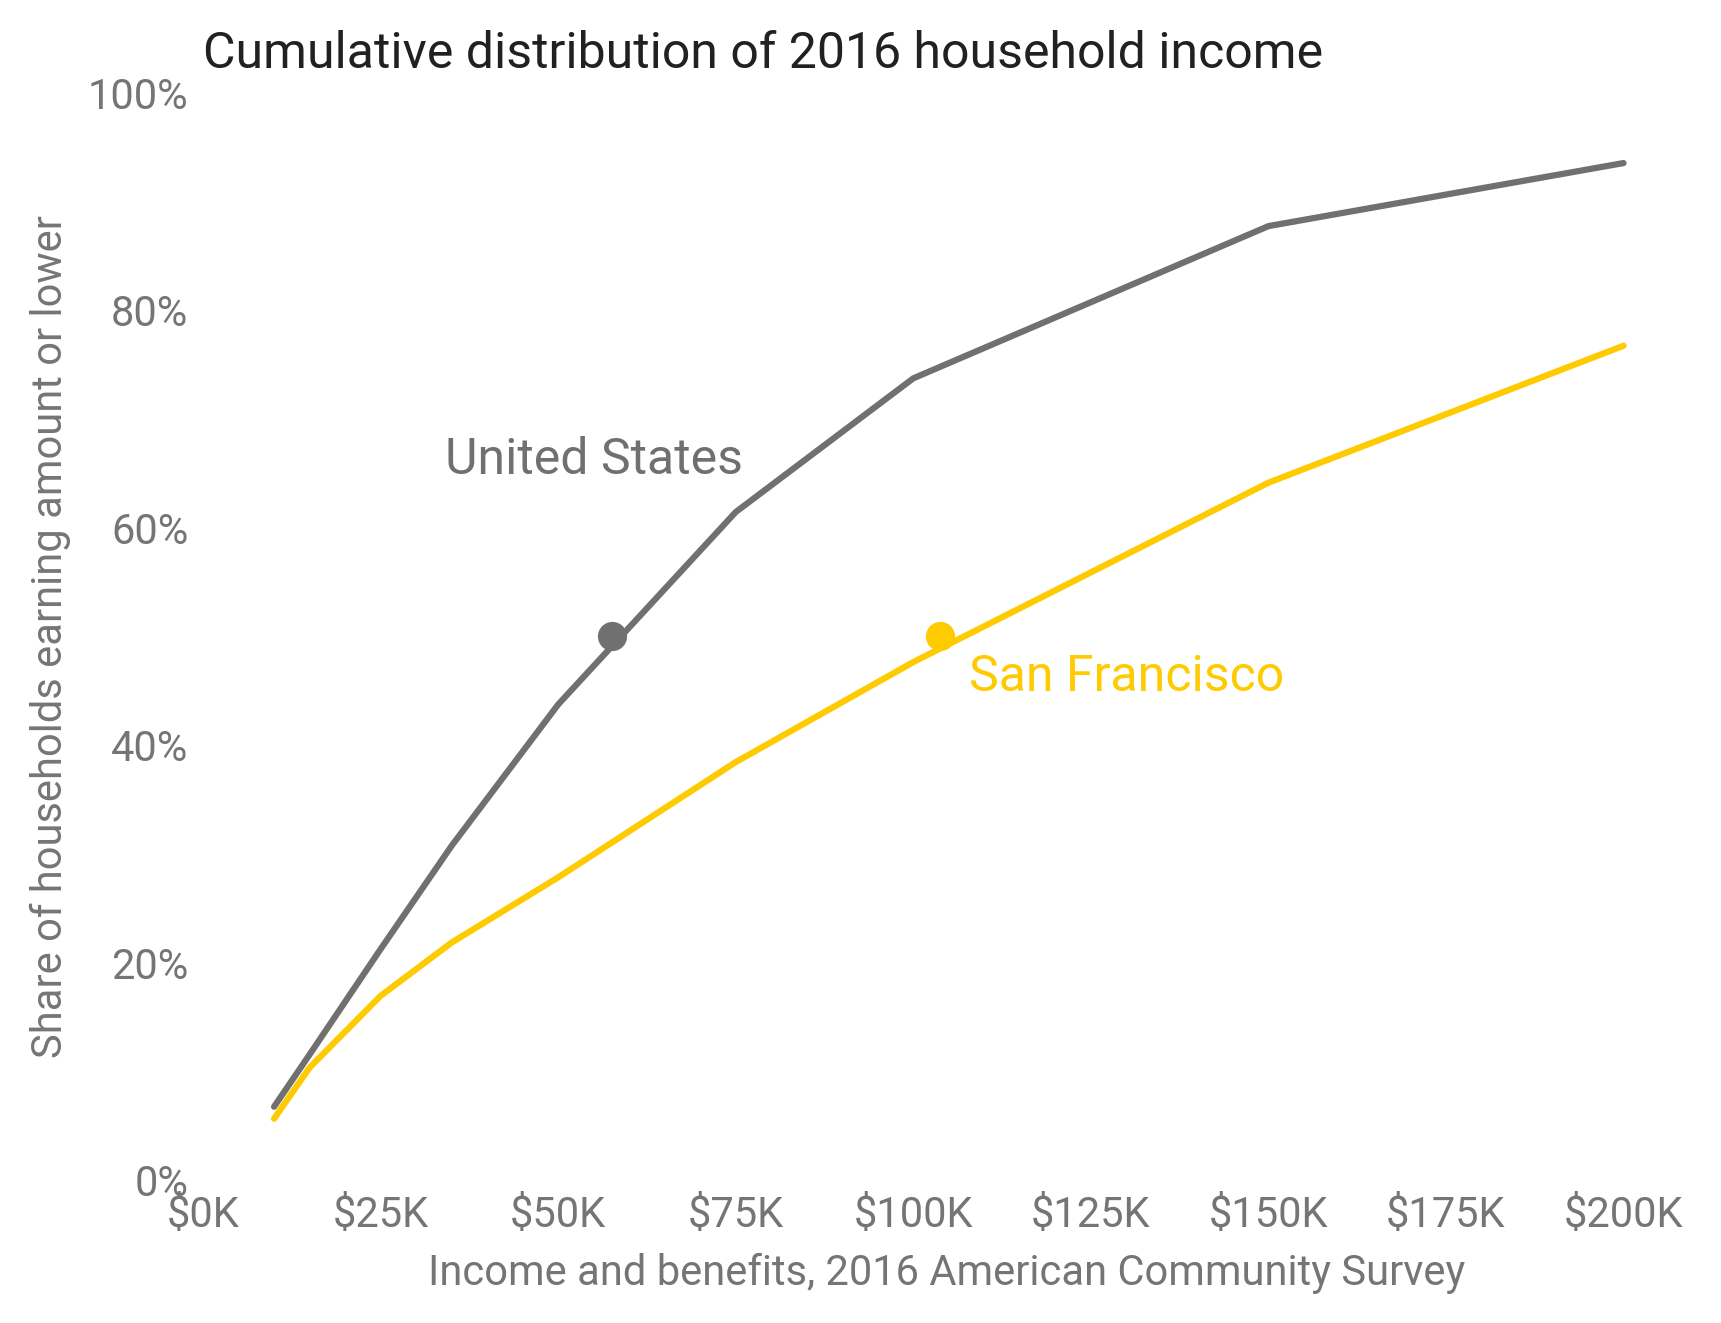

In [221]:
ax = sf_us_t.iloc[:len(sf_us_t) - 1].plot(
    x='max', y=['sf_cumsum', 'us_cumsum'],
    color=[SF_COLOR, US_COLOR]
)
plt.plot(sf_us.loc[sf_us['geo'] == 'US', 'DP03_0062E'], 50, marker='o',
         color=US_COLOR)
plt.plot(sf_us.loc[sf_us['geo'] == 'SF', 'DP03_0062E'], 50, marker='o',
         color=SF_COLOR)
# median.plot(x=[50], y=['sf', 'us'], marker='o', ax=ax)
ax.legend_.remove()
# ax.legend(['San Francisco', 'United States'])
ax.text(55000, 65, 'United States', horizontalalignment='center', 
        color=US_COLOR, size=12)
ax.text(130000, 45, 'San Francisco', horizontalalignment='center', 
        color=SF_COLOR, size=12)
ax.set(xlabel=
       'Income and benefits, 2016 American Community Survey',
       ylabel='Share of households earning amount or lower',
       ylim=(0, 100),
       xlim=0)
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x / 1000), ',') + 
                             'K'))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100)))
plt.title('Cumulative distribution of 2016 household income', 
          loc='left')
plt.show()

### Columns

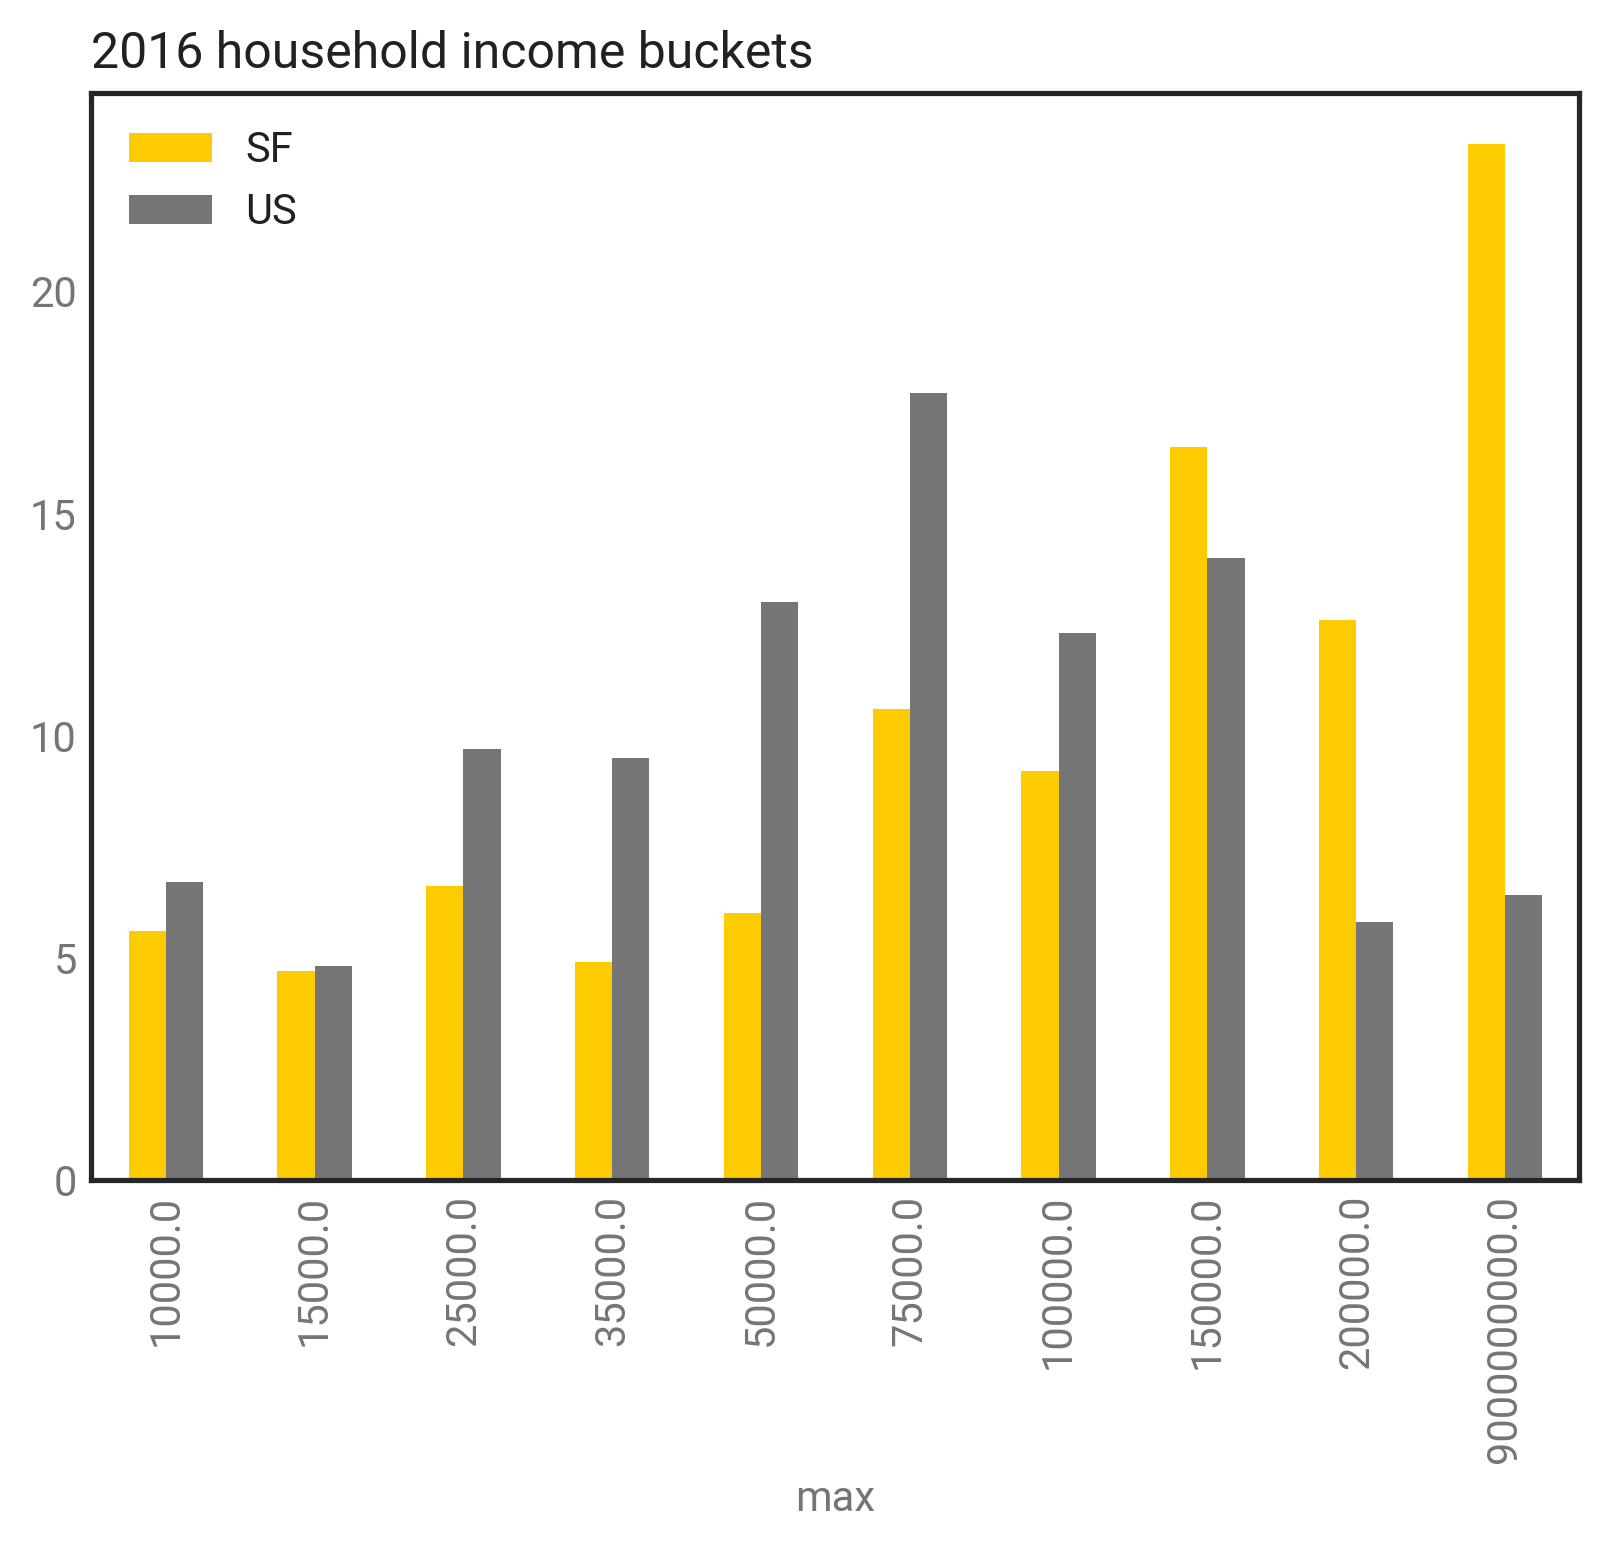

In [165]:
ax = sf_us_t.plot(x='max', y=['SF', 'US'], kind='bar', 
                  color=[SF_COLOR, US_COLOR])
# ax.legend_.remove()
# # ax.legend(['San Francisco', 'United States'])
# ax.text(55000, 65, 'United States', horizontalalignment='center', 
#         color=US_COLOR, size=12)
# ax.text(130000, 45, 'San Francisco', horizontalalignment='center', 
#         color=SF_COLOR, size=12)
# ax.set(xlabel=
#        'Income and benefits, 2016 American Community Survey',
#        ylabel='Share of households earning amount or lower',
#        ylim=(0, 100),
#        xlim=0)
# sns.despine(left=True, bottom=True)
# ax.get_xaxis().set_major_formatter(
#     mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x / 1000), ',') + 
#                              'K'))
# ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
#     lambda y, _: '{:.0%}'.format(y / 100)))
plt.title('2016 household income buckets', loc='left')
plt.show()

## Appendix

Tax unit size distribution.

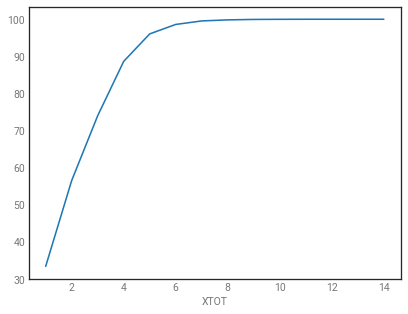

In [51]:
eitcr.groupby('XTOT')['s006_share'].sum().cumsum().plot()
plt.show()

How many get $5k+?

In [47]:
eitcr.loc[eitcr['eitc'] >= 5000, 's006_share'].sum()

12.395280131589635